In [19]:
from typing import Tuple
import numpy as np
import jax.numpy as jnp
from jax import value_and_grad
import jax
import matplotlib.pyplot as plt

import mesher
import examples
import poly_primitives as poly
import geometry_projection as gp
import FE_routines as fe
import mma
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [20]:
bounding_box = mesher.BoundingBox(x_min=0., x_max=60.,
                                  y_min=0., y_max = 30.)
mesh = mesher.Mesher(nelx = 40, nely = 20, bounding_box=bounding_box)

# plot on a higher res mesh
plot_mesh = mesher.Mesher(nelx = 600, nely = 300, bounding_box=bounding_box)

In [21]:
material = fe.Material(youngs_modulus=1.,
                       poissons_ratio=0.3,
                       delta_youngs_modulus=1e-3)

In [22]:
bc = examples.get_sample_bc(mesh, examples.SampleBoundaryConditions.MBB_BEAM)

In [23]:
nxb, nyb = 3, 2
num_polys = nxb*nyb
num_planes_in_a_poly = 6
max_angle_offset = 2*np.pi
poly_extents = poly.PolygonExtents(num_polys=num_polys,
                          num_planes_in_a_poly=num_planes_in_a_poly,
                          min_center_x=-0.,
                          min_center_y=-0., 
                          max_center_x=mesh.lx,
                          max_center_y=mesh.ly,
                          min_face_offset=-0.1*mesh.lx,
                          max_face_offset=0.5*mesh.lx,
                          min_angle_offset=0.,
                          max_angle_offset= max_angle_offset)

In [24]:
# init_geom = poly.init_random_polys(poly_extents)
init_geom = poly.init_poly_grid(nxb, nyb, poly_extents)

In [25]:
fe_solver = fe.FEA(mesh, material, bc)
lossfn = fe_solver.loss_function

In [26]:
def plot_polygons(polygons: poly.ConvexPolys, mesh: mesher.Mesher,
                  status = '', save_fig_as = None):
  """
  Each blob gets a different random color.
  """
  
  # get the density of each blob
  sdf = poly.compute_poly_sdf(polygons, mesh)
  density = gp.project_primitive_sdf_to_density(sdf, mesh, 100)

  red_color = np.zeros((density.shape[0], 4))
  red_color[:,0] = 1.; red_color[:,1] = 0.;
  red_color[:,2] = 0.; red_color[:,3] = 0.5; 

  grayness = 0.98 # bg color to slight gray
  composite_img = ( np.clip(
    np.einsum('bc, be -> ec', red_color, density), a_min=0.05, a_max=grayness))

  plt.figure()
  plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  plt.imshow(composite_img.reshape((mesh.nelx, mesh.nely, 4)).transpose((1, 0, 2)),
            origin='lower')
  plt.axis('off')
  plt.title(status)
  
  if save_fig_as is not None:
    plt.savefig(save_fig_as)
  plt.show()


def primitive_to_density(primitives, mesh):
  sdf = poly.compute_poly_sdf(primitives, mesh)
  density = gp.project_primitive_sdf_to_density(sdf, mesh)
  return gp.compute_union_density_fields(density)


class Optimizer:
  def __init__(self, lossfn: callable,
               mesh: mesher.Mesher,
               polyg_extents: poly.PolygonExtents):
    self.lossfn, self.mesh = lossfn, mesh
    self.polyg_extents = polyg_extents
  #-----------------------#
  def constraint_fn(self, design_variable: jnp.ndarray,
                        max_vol_frac: float,
                        allowed_min_edge_length: float) -> Tuple[jnp.ndarray, jnp.ndarray]:

    def volume_constraint(design_variable:jnp.ndarray)-> float:
      self.geometry = poly.ConvexPolys.from_normalized_array(
            design_variable.reshape((-1)), self.polyg_extents)

      density = primitive_to_density(self.geometry, self.mesh)

      occupied_volume = self.mesh.elem_area*jnp.sum(density)
      volcons =  occupied_volume/(max_vol_frac*self.mesh.domain_volume) - 1.
      return volcons
    vc, dvc = value_and_grad(volume_constraint)(design_variable)

    def min_edge_length_constraint(design_variable:jnp.ndarray)-> float:
      polygons = poly.ConvexPolys.from_normalized_array(
            design_variable.reshape((-1)), self.polyg_extents)
      min_edge_length = poly.compute_min_edge_length_of_polygons(polygons)
      return 1. - (min_edge_length/allowed_min_edge_length)
    elc, delc = value_and_grad(min_edge_length_constraint)(design_variable)
    
    c = jnp.vstack((vc, elc))
    dc = jnp.hstack((dvc, delc)).T
    return c, dc
  #-----------------------#
  def objective_fn(self, design_var: jnp.ndarray)-> Tuple[jnp.ndarray,
                                                          jnp.ndarray]:
    def obj_wrapper(design_var: jnp.ndarray)->jnp.ndarray:
      self.geometry = poly.ConvexPolys.from_normalized_array(
        design_var.reshape((-1)), self.polyg_extents)
      density = primitive_to_density(self.geometry, self.mesh)
      compliance = self.lossfn(density)
      return compliance
    obj, grad_obj = value_and_grad(obj_wrapper)(design_var)
    return obj, grad_obj.reshape((-1, 1))
  #-----------------------#
  def optimize(self, init_geom: poly.ConvexPolys,
               max_vol_frac: float, allowed_min_edge_length: float,
               max_iter: int,
               kkt_tol: float=1e-6, step_tol: float=1e-6, move_limit: float=1e-2,
               plot_interval: int=5):

    self.num_design_var = init_geom.num_free_parameters
    self.geometry = init_geom
    self.design_var = self.geometry.to_normalized_array(
      self.polyg_extents).reshape((-1, 1))
    lower_bound = np.zeros((self.num_design_var, 1))
    upper_bound = np.ones((self.num_design_var, 1))
    mma_params = mma.MMAParams(
        max_iter=max_iter,
        kkt_tol=kkt_tol,
        step_tol=step_tol,
        move_limit=move_limit,
        num_design_var=self.num_design_var,
        num_cons=2,
        lower_bound=lower_bound,
        upper_bound=upper_bound,
    )
    mma_state = mma.init_mma(self.design_var, mma_params)
    def plotfun(x, status = ''):
      polygons = poly.ConvexPolys.from_normalized_array(
                    x.reshape((-1)), self.polyg_extents)
      plot_polygons(polygons, plot_mesh, status=status,
                    save_fig_as = f'./frames/iter_{mma_state.epoch}.svg')

    history = {'obj':[], 'vol_cons':[], 'edge_len_cons':[]}

    while not mma_state.is_converged:
      objective, grad_obj = self.objective_fn(mma_state.x)
      constr, grad_cons = self.constraint_fn(mma_state.x, max_vol_frac,
                                             allowed_min_edge_length)
      mma_state = mma.update_mma(
        mma_state, mma_params, objective, grad_obj, constr, grad_cons
      )

      status = (f'epoch {mma_state.epoch:d} obj {objective:.2E} '
                f'vol cons {constr[0,0]:.2E} edge_len_cons {constr[1,0]:.2E} ')
      history['obj'].append(objective)
      history['vol_cons'].append(constr[0,0])
      history['edge_len_cons'].append(constr[1,0])
      
      print(status)
      if mma_state.epoch%plot_interval == 0 or mma_state.epoch==1:
        plotfun(mma_state.x, status)


    return mma_state, history

epoch 1 obj 3.28E+03 vol cons -6.75E-01 edge_len_cons -1.09E+00 


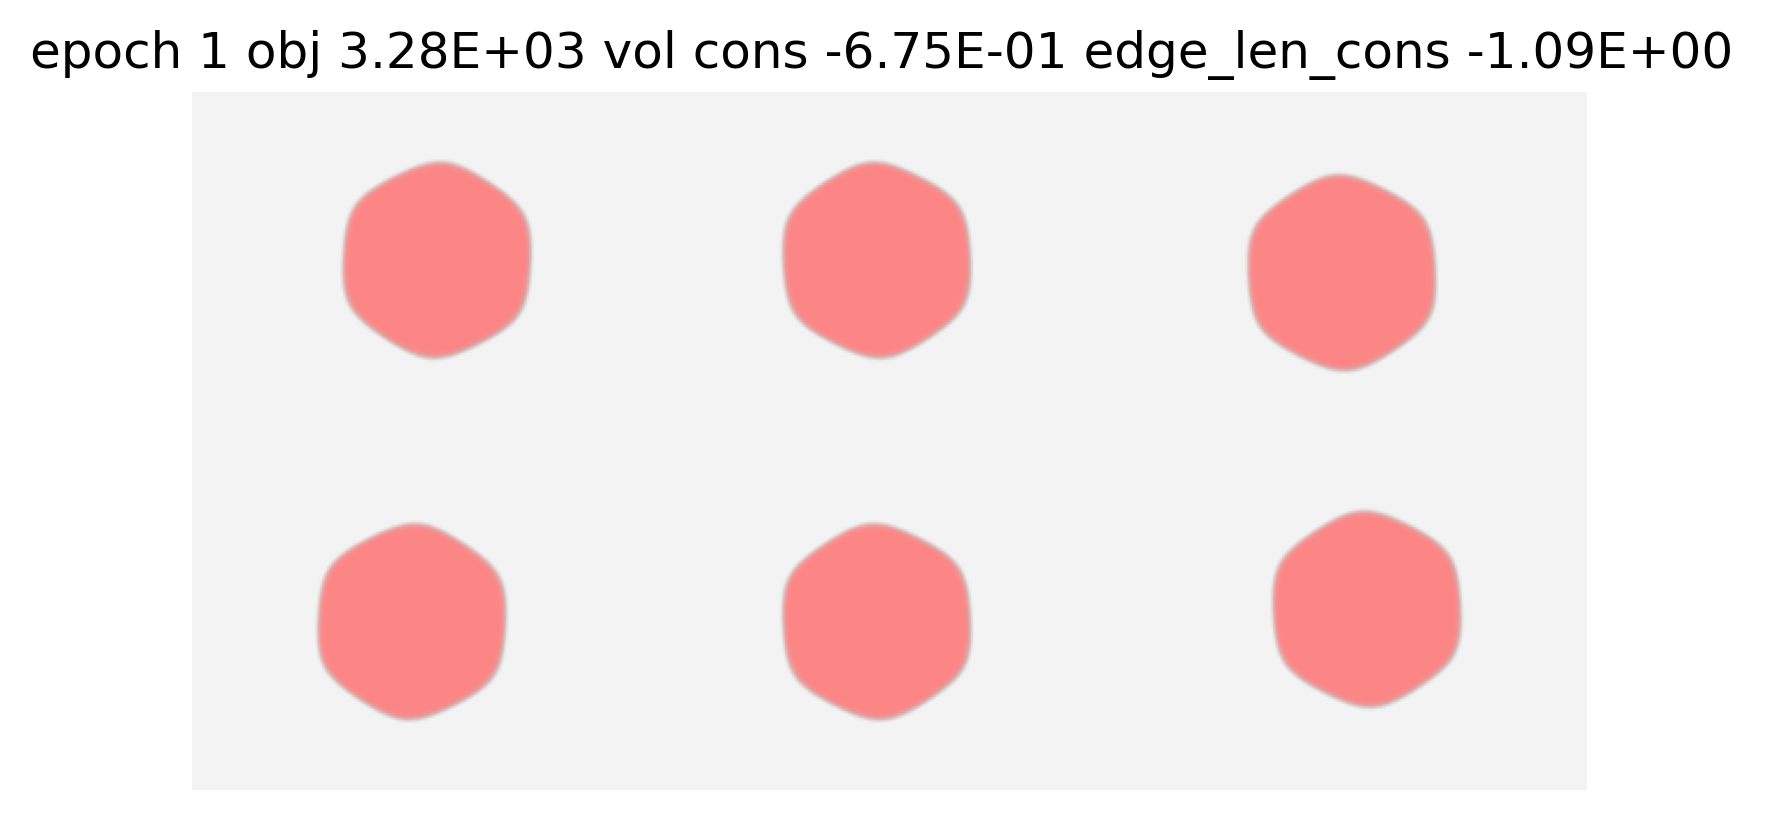

epoch 2 obj 3.05E+03 vol cons -6.16E-01 edge_len_cons -1.27E+00 
epoch 3 obj 2.82E+03 vol cons -5.53E-01 edge_len_cons -1.45E+00 
epoch 4 obj 2.55E+03 vol cons -4.78E-01 edge_len_cons -1.65E+00 
epoch 5 obj 2.24E+03 vol cons -3.98E-01 edge_len_cons -1.85E+00 
epoch 6 obj 1.94E+03 vol cons -3.14E-01 edge_len_cons -2.05E+00 
epoch 7 obj 1.57E+03 vol cons -2.32E-01 edge_len_cons -2.25E+00 
epoch 8 obj 1.30E+03 vol cons -1.55E-01 edge_len_cons -2.45E+00 
epoch 9 obj 9.81E+02 vol cons -8.07E-02 edge_len_cons -2.65E+00 
epoch 10 obj 6.47E+02 vol cons -3.49E-02 edge_len_cons -2.62E+00 
epoch 11 obj 5.05E+02 vol cons -2.86E-02 edge_len_cons -2.40E+00 
epoch 12 obj 4.20E+02 vol cons -1.87E-02 edge_len_cons -2.16E+00 
epoch 13 obj 3.39E+02 vol cons -2.00E-02 edge_len_cons -1.95E+00 
epoch 14 obj 2.98E+02 vol cons -1.86E-02 edge_len_cons -1.74E+00 
epoch 15 obj 2.58E+02 vol cons -2.14E-02 edge_len_cons -1.34E+00 
epoch 16 obj 2.29E+02 vol cons -1.44E-02 edge_len_cons -1.13E+00 
epoch 17 obj 2.02E

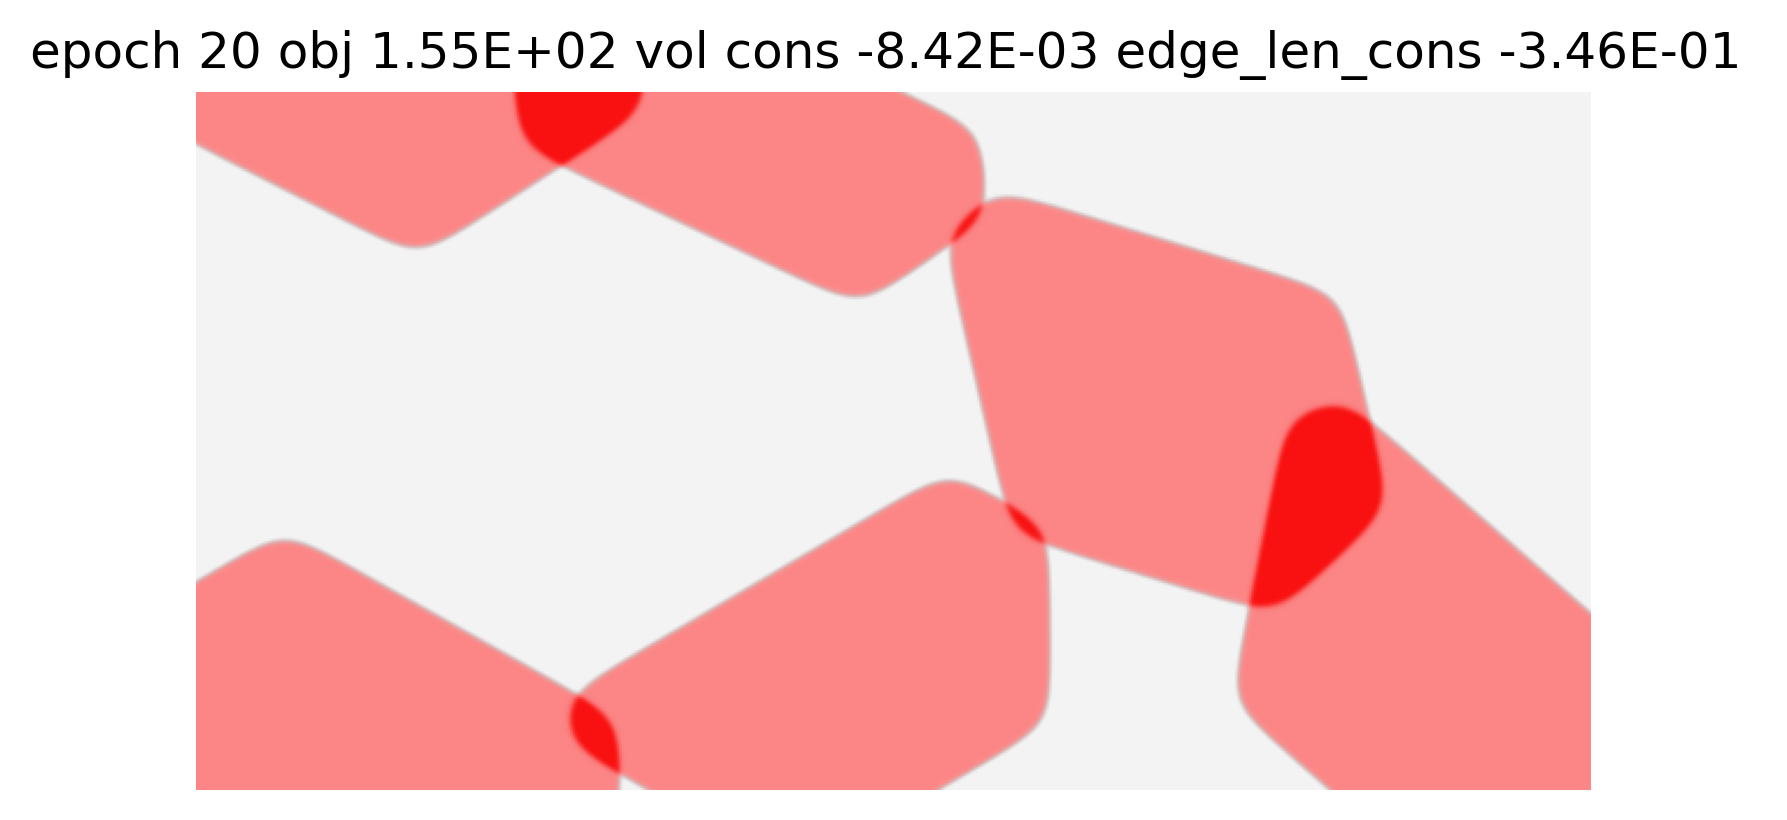

epoch 21 obj 1.47E+02 vol cons -4.82E-03 edge_len_cons -1.22E-02 
epoch 22 obj 1.40E+02 vol cons -3.51E-03 edge_len_cons 3.69E-02 
epoch 23 obj 1.34E+02 vol cons -5.87E-03 edge_len_cons 3.39E-02 
epoch 24 obj 1.29E+02 vol cons -4.58E-03 edge_len_cons 1.52E-01 
epoch 25 obj 1.25E+02 vol cons -6.44E-03 edge_len_cons 1.70E-01 
epoch 26 obj 1.22E+02 vol cons -4.09E-03 edge_len_cons 5.34E-02 
epoch 27 obj 1.21E+02 vol cons -6.86E-03 edge_len_cons 2.32E-01 
epoch 28 obj 1.19E+02 vol cons -4.95E-03 edge_len_cons 9.52E-02 
epoch 29 obj 1.16E+02 vol cons -3.11E-03 edge_len_cons 8.89E-02 
epoch 30 obj 1.14E+02 vol cons -3.15E-03 edge_len_cons 1.10E-01 
epoch 31 obj 1.13E+02 vol cons -2.28E-03 edge_len_cons 9.82E-02 
epoch 32 obj 1.12E+02 vol cons -1.23E-03 edge_len_cons 1.21E-01 
epoch 33 obj 1.12E+02 vol cons -2.25E-03 edge_len_cons 3.99E-02 
epoch 34 obj 1.11E+02 vol cons -1.75E-03 edge_len_cons 1.28E-02 
epoch 35 obj 1.10E+02 vol cons -2.21E-03 edge_len_cons 3.78E-02 
epoch 36 obj 1.09E+02 vo

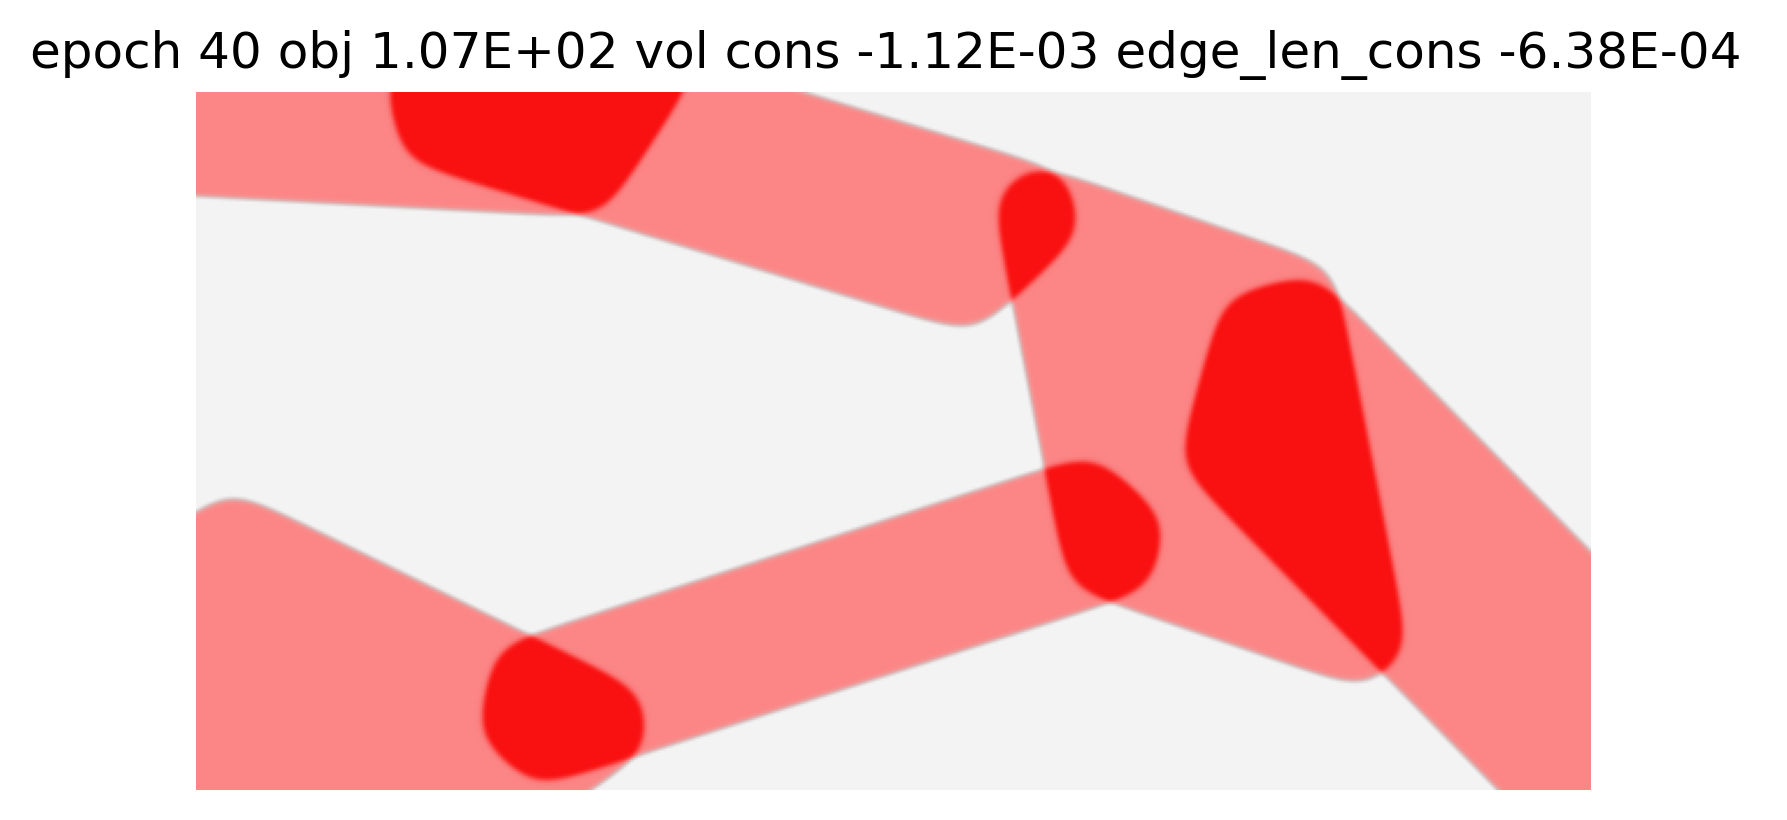

epoch 41 obj 1.07E+02 vol cons -1.20E-03 edge_len_cons 4.67E-03 
epoch 42 obj 1.06E+02 vol cons -8.66E-04 edge_len_cons 1.22E-03 
epoch 43 obj 1.06E+02 vol cons -6.21E-04 edge_len_cons 7.58E-03 
epoch 44 obj 1.06E+02 vol cons -7.04E-04 edge_len_cons -1.53E-02 
epoch 45 obj 1.05E+02 vol cons -6.75E-04 edge_len_cons -2.30E-02 
epoch 46 obj 1.05E+02 vol cons -5.60E-04 edge_len_cons -3.09E-03 
epoch 47 obj 1.05E+02 vol cons -7.69E-05 edge_len_cons -1.79E-02 
epoch 48 obj 1.05E+02 vol cons -3.73E-04 edge_len_cons -1.08E-02 
epoch 49 obj 1.05E+02 vol cons -1.62E-04 edge_len_cons 8.63E-04 
epoch 50 obj 1.05E+02 vol cons 7.01E-05 edge_len_cons 6.86E-03 
epoch 51 obj 1.04E+02 vol cons -1.86E-04 edge_len_cons 2.05E-03 
epoch 52 obj 1.04E+02 vol cons 1.20E-04 edge_len_cons 1.66E-02 
epoch 53 obj 1.04E+02 vol cons 1.03E-03 edge_len_cons 2.48E-02 
epoch 54 obj 1.04E+02 vol cons -1.15E-04 edge_len_cons 2.73E-02 
epoch 55 obj 1.04E+02 vol cons -8.55E-05 edge_len_cons 8.53E-03 
epoch 56 obj 1.04E+02 v

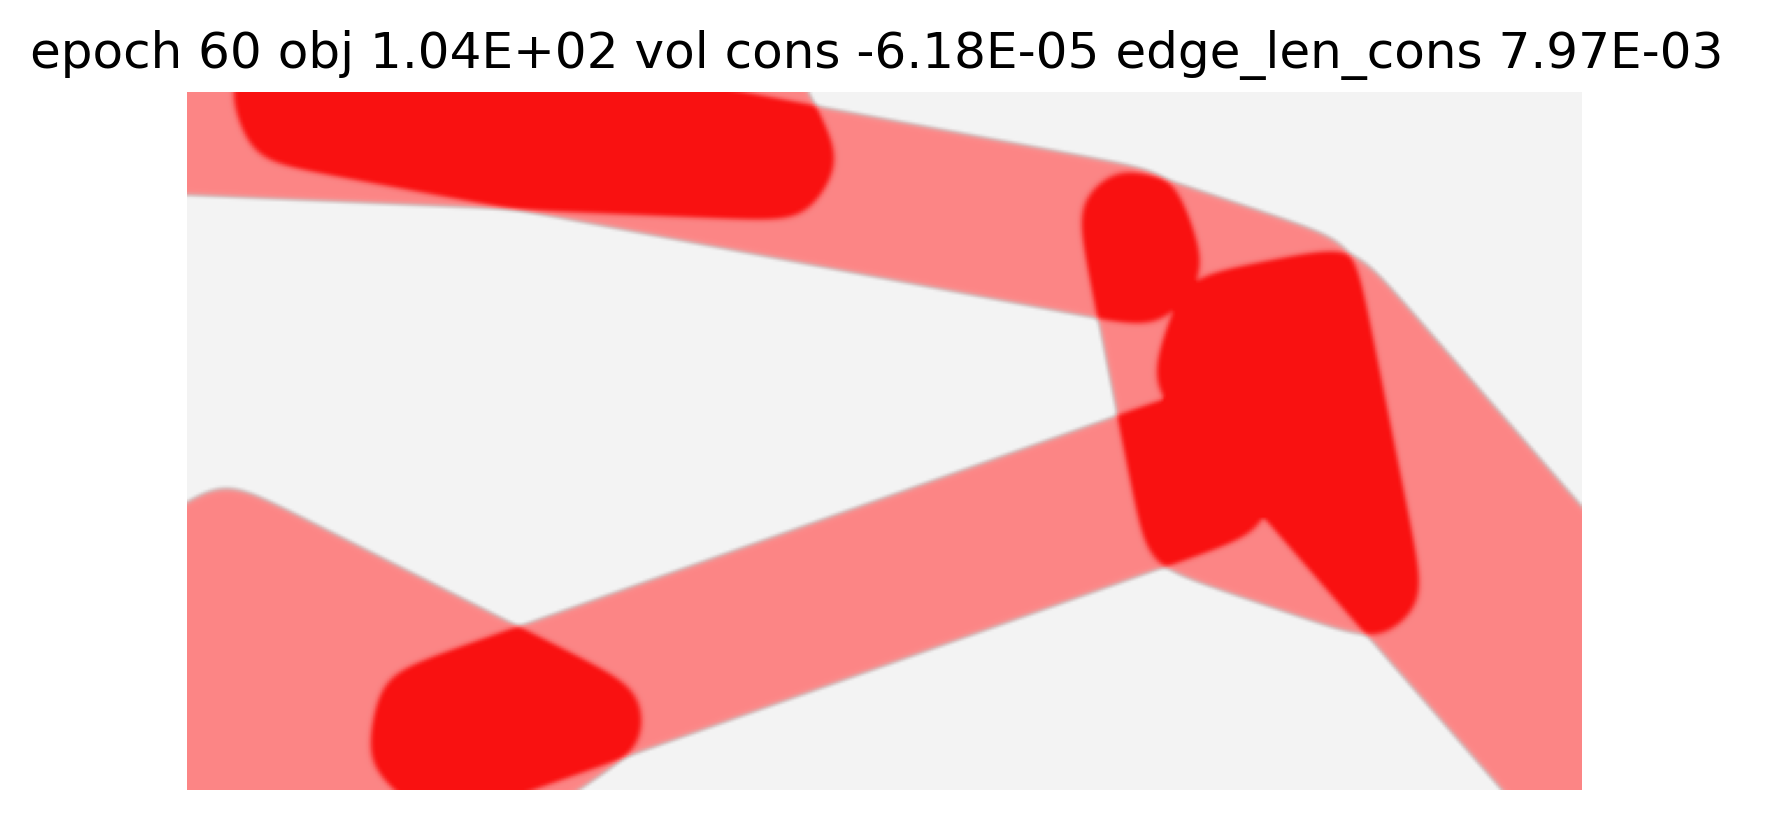

epoch 61 obj 1.04E+02 vol cons -1.40E-04 edge_len_cons 9.00E-03 
epoch 62 obj 1.04E+02 vol cons -1.35E-04 edge_len_cons 1.51E-02 
epoch 63 obj 1.04E+02 vol cons -2.69E-04 edge_len_cons 1.48E-02 
epoch 64 obj 1.04E+02 vol cons -6.97E-05 edge_len_cons 9.46E-03 
epoch 65 obj 1.04E+02 vol cons -6.11E-05 edge_len_cons 7.15E-03 
epoch 66 obj 1.04E+02 vol cons 1.11E-05 edge_len_cons 9.85E-03 
epoch 67 obj 1.04E+02 vol cons -2.13E-05 edge_len_cons 5.80E-03 
epoch 68 obj 1.04E+02 vol cons -1.59E-05 edge_len_cons 3.97E-03 
epoch 69 obj 1.04E+02 vol cons -1.56E-05 edge_len_cons 3.36E-03 
epoch 70 obj 1.04E+02 vol cons -1.63E-05 edge_len_cons 3.37E-03 
epoch 71 obj 1.04E+02 vol cons -2.00E-05 edge_len_cons 4.71E-03 
epoch 72 obj 1.04E+02 vol cons -2.13E-05 edge_len_cons 1.25E-02 
epoch 73 obj 1.04E+02 vol cons -2.40E-05 edge_len_cons 1.57E-02 
epoch 74 obj 1.04E+02 vol cons -2.33E-04 edge_len_cons 7.07E-03 
epoch 75 obj 1.04E+02 vol cons 8.34E-05 edge_len_cons 3.03E-02 
epoch 76 obj 1.04E+02 vol c

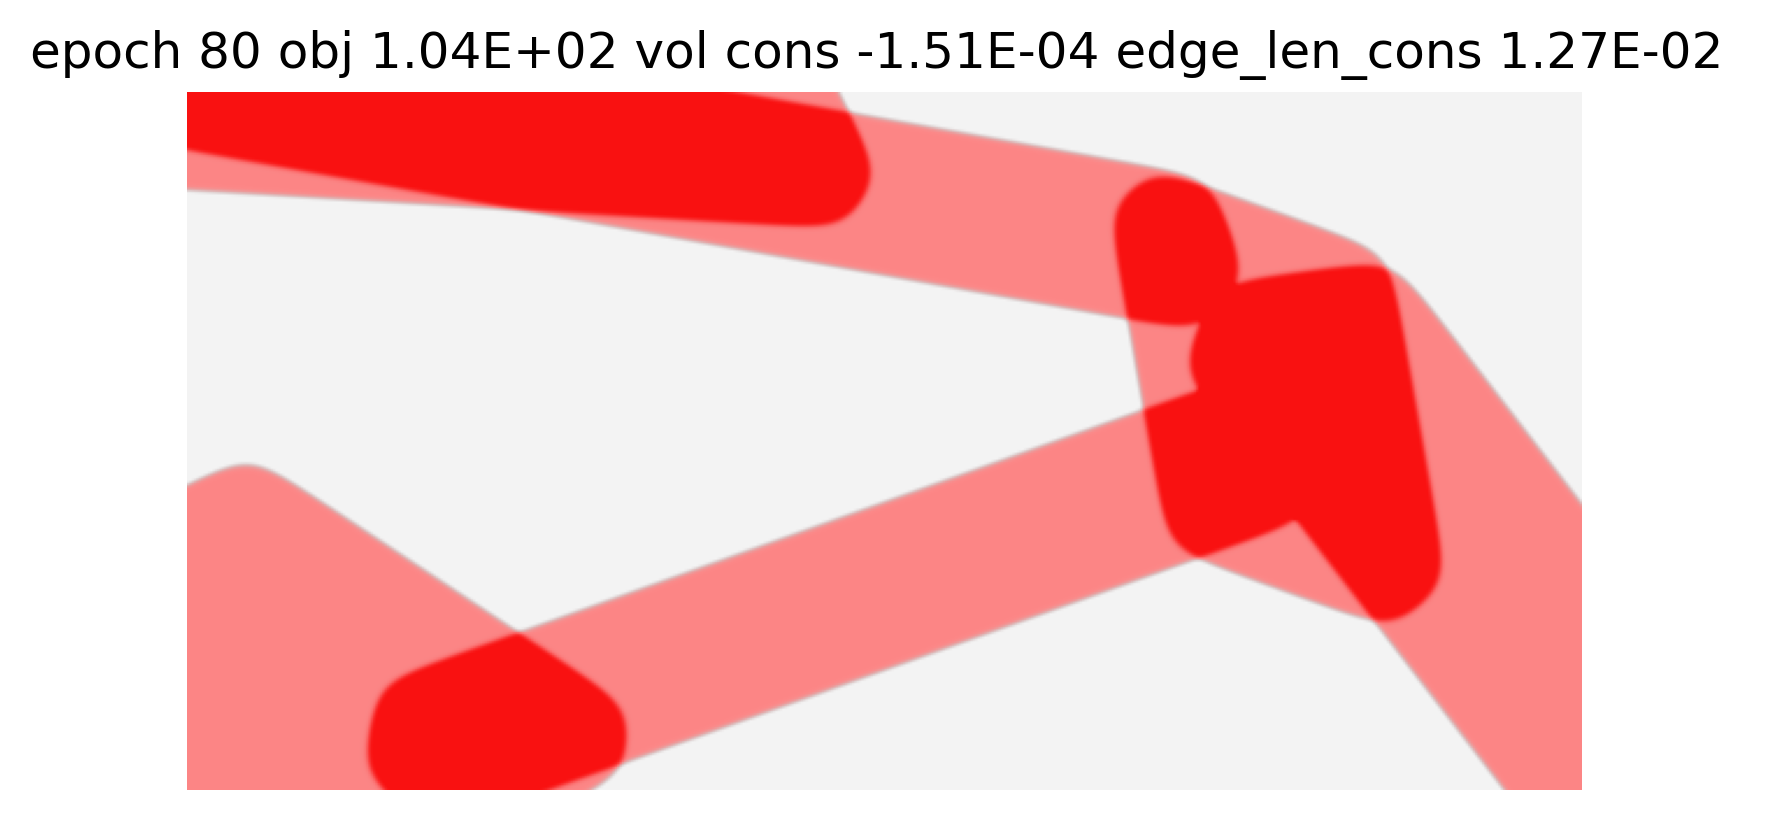

epoch 81 obj 1.04E+02 vol cons 7.63E-05 edge_len_cons 6.72E-03 
epoch 82 obj 1.04E+02 vol cons 2.46E-04 edge_len_cons 3.22E-03 
epoch 83 obj 1.04E+02 vol cons -6.85E-06 edge_len_cons -6.57E-04 
epoch 84 obj 1.04E+02 vol cons -1.85E-05 edge_len_cons -3.10E-04 
epoch 85 obj 1.04E+02 vol cons -2.08E-04 edge_len_cons 4.72E-03 
epoch 86 obj 1.04E+02 vol cons -3.15E-05 edge_len_cons 5.31E-03 
epoch 87 obj 1.04E+02 vol cons -1.75E-05 edge_len_cons 3.02E-03 
epoch 88 obj 1.04E+02 vol cons -1.47E-05 edge_len_cons 1.38E-03 
epoch 89 obj 1.04E+02 vol cons -4.83E-05 edge_len_cons 2.74E-03 
epoch 90 obj 1.04E+02 vol cons 1.19E-07 edge_len_cons 3.91E-04 
epoch 91 obj 1.04E+02 vol cons -4.59E-06 edge_len_cons 9.71E-03 
epoch 92 obj 1.04E+02 vol cons -4.30E-05 edge_len_cons 1.31E-02 
epoch 93 obj 1.04E+02 vol cons -3.80E-05 edge_len_cons 1.80E-02 
epoch 94 obj 1.04E+02 vol cons -3.58E-06 edge_len_cons 7.63E-03 
epoch 95 obj 1.04E+02 vol cons -5.84E-06 edge_len_cons 8.93E-03 
epoch 96 obj 1.04E+02 vol 

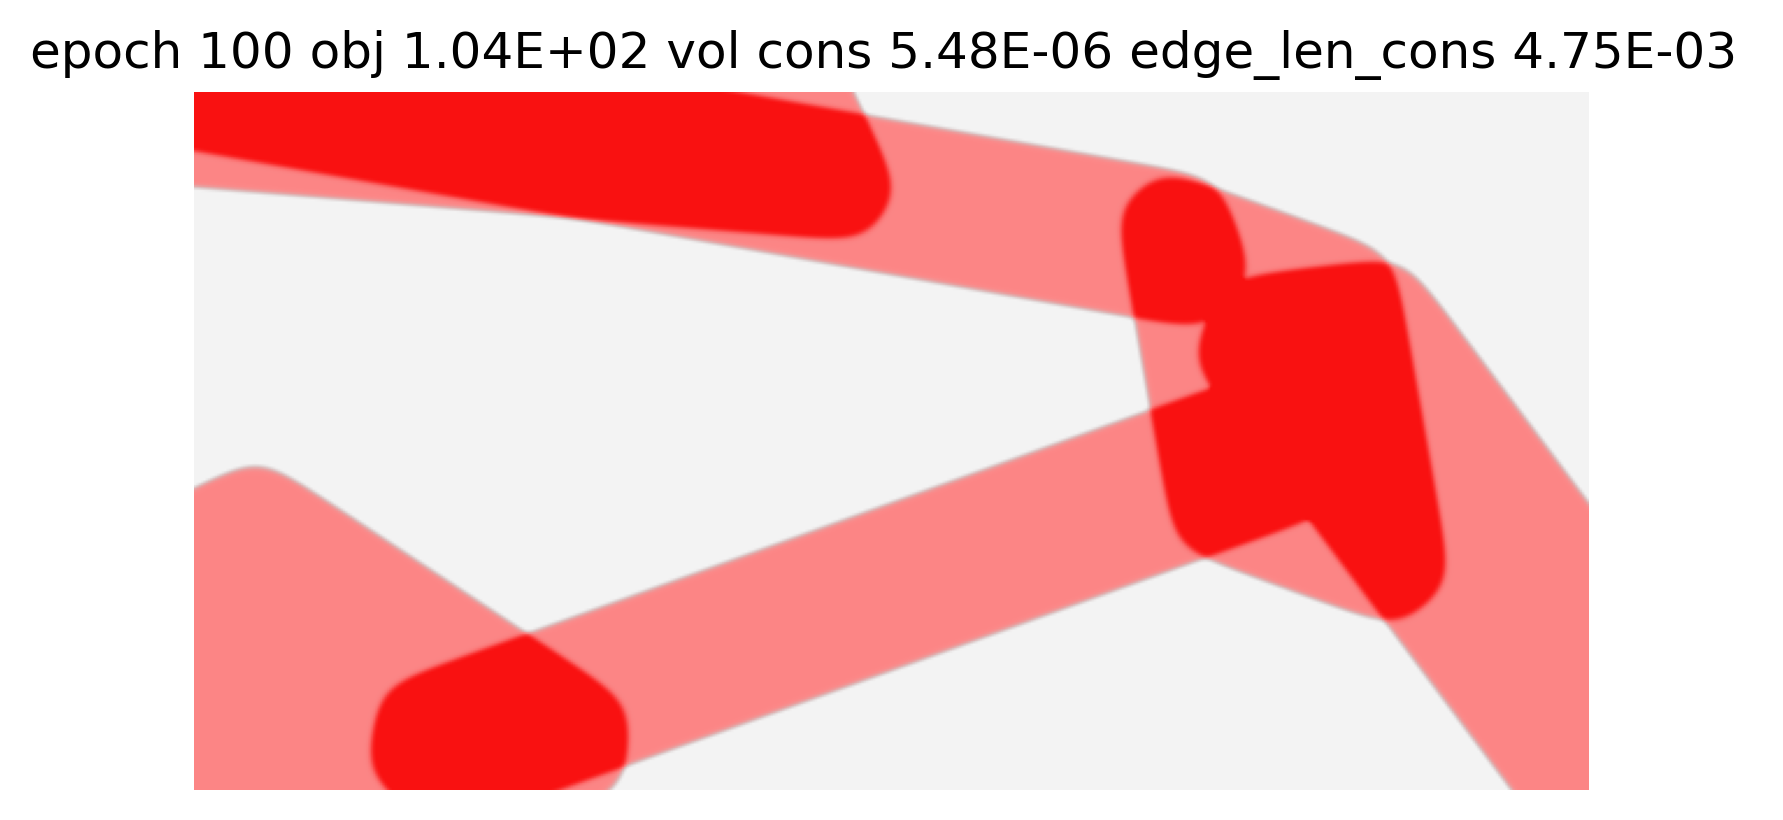

epoch 101 obj 1.04E+02 vol cons -1.57E-05 edge_len_cons 6.61E-03 
epoch 102 obj 1.04E+02 vol cons -4.83E-06 edge_len_cons 3.12E-03 
epoch 103 obj 1.04E+02 vol cons -9.54E-07 edge_len_cons 8.46E-04 
epoch 104 obj 1.04E+02 vol cons -3.52E-06 edge_len_cons -1.81E-05 
epoch 105 obj 1.04E+02 vol cons -1.53E-05 edge_len_cons 3.46E-04 
epoch 106 obj 1.04E+02 vol cons -3.46E-05 edge_len_cons 3.15E-04 
epoch 107 obj 1.04E+02 vol cons -3.48E-05 edge_len_cons 9.59E-04 
epoch 108 obj 1.04E+02 vol cons -6.02E-06 edge_len_cons -1.90E-04 
epoch 109 obj 1.04E+02 vol cons -6.56E-07 edge_len_cons 1.38E-04 
epoch 110 obj 1.04E+02 vol cons -1.79E-06 edge_len_cons 1.83E-04 
epoch 111 obj 1.04E+02 vol cons -6.08E-06 edge_len_cons 7.62E-05 
epoch 112 obj 1.04E+02 vol cons -4.29E-06 edge_len_cons 7.36E-05 
epoch 113 obj 1.04E+02 vol cons -3.28E-06 edge_len_cons 2.14E-04 
epoch 114 obj 1.04E+02 vol cons -6.56E-07 edge_len_cons 2.13E-04 
epoch 115 obj 1.04E+02 vol cons -3.87E-06 edge_len_cons 2.92E-04 
epoch 11

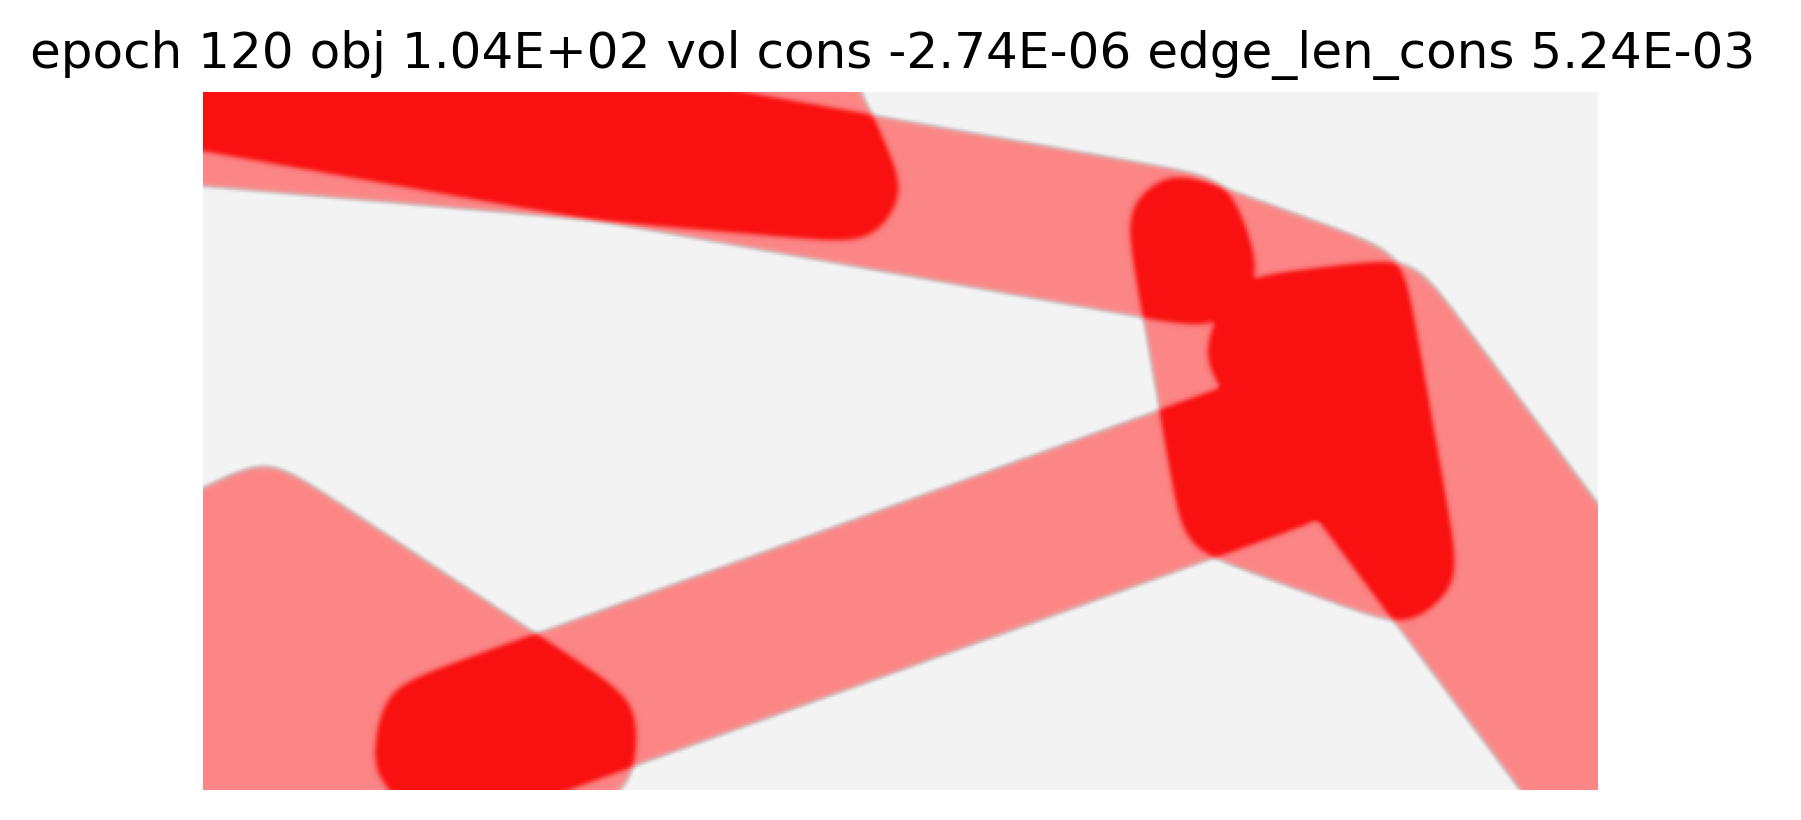

epoch 121 obj 1.04E+02 vol cons -9.54E-07 edge_len_cons 2.60E-03 
epoch 122 obj 1.04E+02 vol cons -2.50E-06 edge_len_cons 1.63E-02 
epoch 123 obj 1.04E+02 vol cons -8.58E-06 edge_len_cons 1.24E-02 
epoch 124 obj 1.04E+02 vol cons -3.46E-06 edge_len_cons 1.29E-02 
epoch 125 obj 1.04E+02 vol cons -2.44E-06 edge_len_cons 6.97E-03 
epoch 126 obj 1.04E+02 vol cons -2.03E-06 edge_len_cons 4.36E-03 
epoch 127 obj 1.04E+02 vol cons -5.48E-06 edge_len_cons 2.64E-03 
epoch 128 obj 1.04E+02 vol cons -1.13E-06 edge_len_cons 1.51E-03 
epoch 129 obj 1.04E+02 vol cons -1.79E-07 edge_len_cons 1.53E-04 
epoch 130 obj 1.04E+02 vol cons -5.36E-07 edge_len_cons 4.11E-05 
epoch 131 obj 1.04E+02 vol cons -2.38E-06 edge_len_cons 2.99E-05 
epoch 132 obj 1.04E+02 vol cons -1.20E-05 edge_len_cons 3.04E-05 
epoch 133 obj 1.04E+02 vol cons -5.36E-07 edge_len_cons 6.67E-05 
epoch 134 obj 1.04E+02 vol cons -4.35E-06 edge_len_cons 5.70E-05 
epoch 135 obj 1.04E+02 vol cons -1.19E-07 edge_len_cons 7.75E-05 
epoch 136 

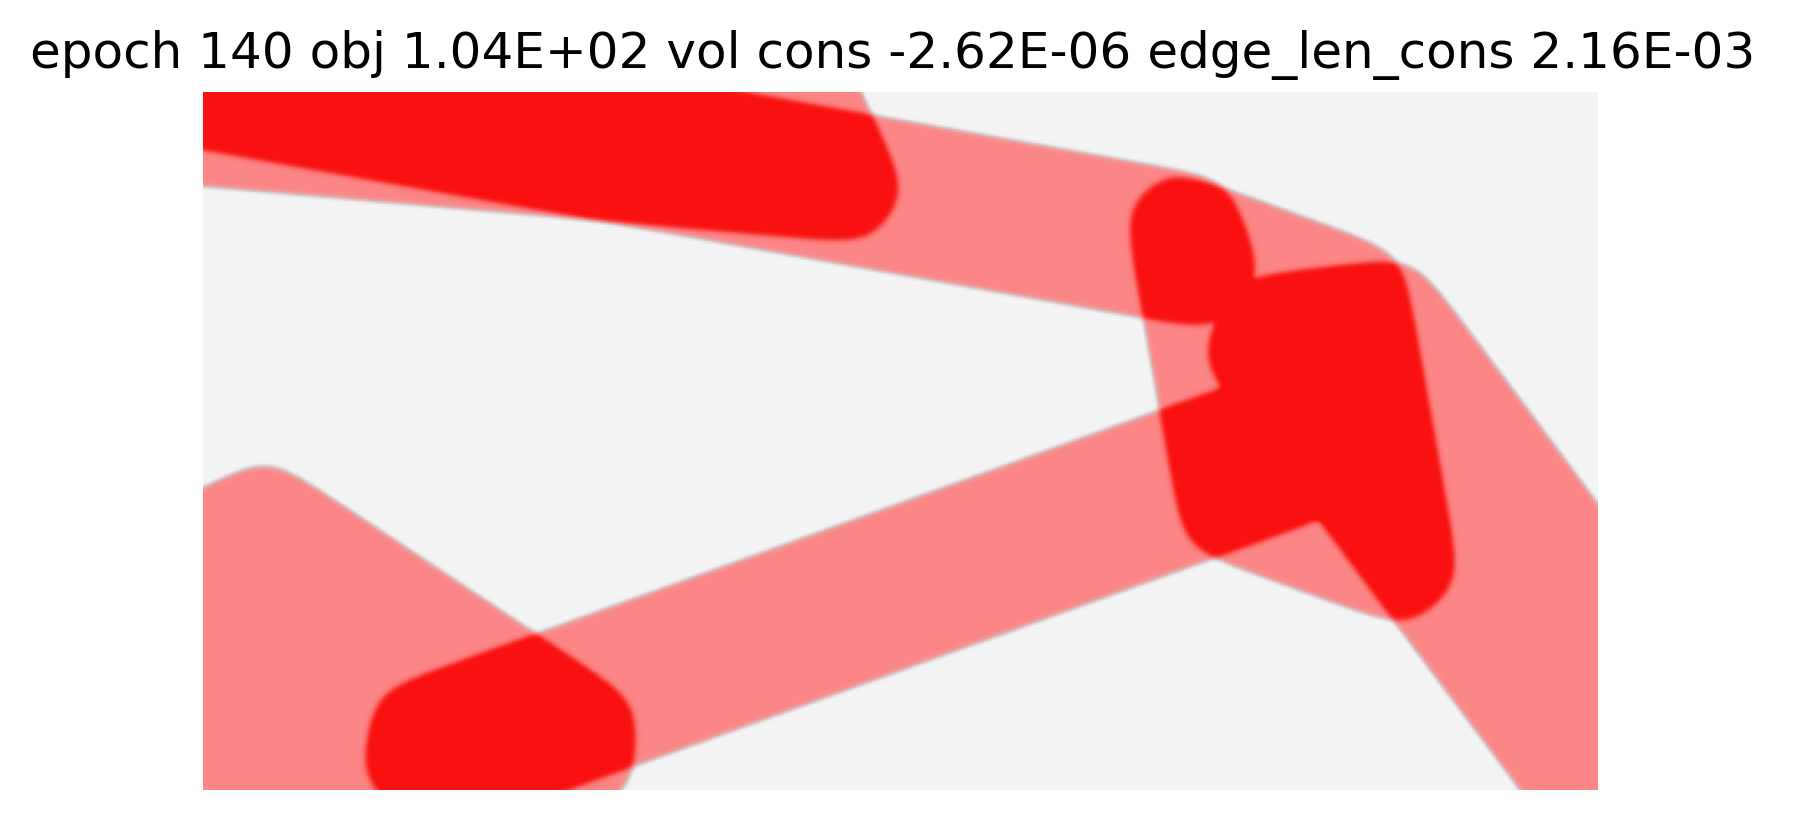

epoch 141 obj 1.04E+02 vol cons -5.96E-07 edge_len_cons 1.57E-03 
epoch 142 obj 1.04E+02 vol cons -6.56E-07 edge_len_cons 1.34E-03 
epoch 143 obj 1.04E+02 vol cons -3.87E-06 edge_len_cons 4.47E-03 
epoch 144 obj 1.04E+02 vol cons -4.83E-06 edge_len_cons 3.04E-03 
epoch 145 obj 1.04E+02 vol cons -1.19E-06 edge_len_cons 1.82E-03 
epoch 146 obj 1.04E+02 vol cons -1.79E-07 edge_len_cons 2.72E-04 
epoch 147 obj 1.04E+02 vol cons -5.96E-08 edge_len_cons 5.73E-05 
epoch 148 obj 1.04E+02 vol cons -1.79E-07 edge_len_cons 4.97E-05 
epoch 149 obj 1.04E+02 vol cons -1.01E-06 edge_len_cons 4.45E-05 
epoch 150 obj 1.04E+02 vol cons 1.67E-06 edge_len_cons -7.67E-05 
epoch 151 obj 1.04E+02 vol cons -1.01E-06 edge_len_cons 1.76E-04 
epoch 152 obj 1.04E+02 vol cons -2.98E-07 edge_len_cons 1.85E-06 
epoch 153 obj 1.04E+02 vol cons 1.19E-07 edge_len_cons 7.11E-05 
epoch 154 obj 1.04E+02 vol cons 0.00E+00 edge_len_cons 6.14E-05 
epoch 155 obj 1.04E+02 vol cons -2.98E-07 edge_len_cons 7.58E-05 
epoch 156 ob

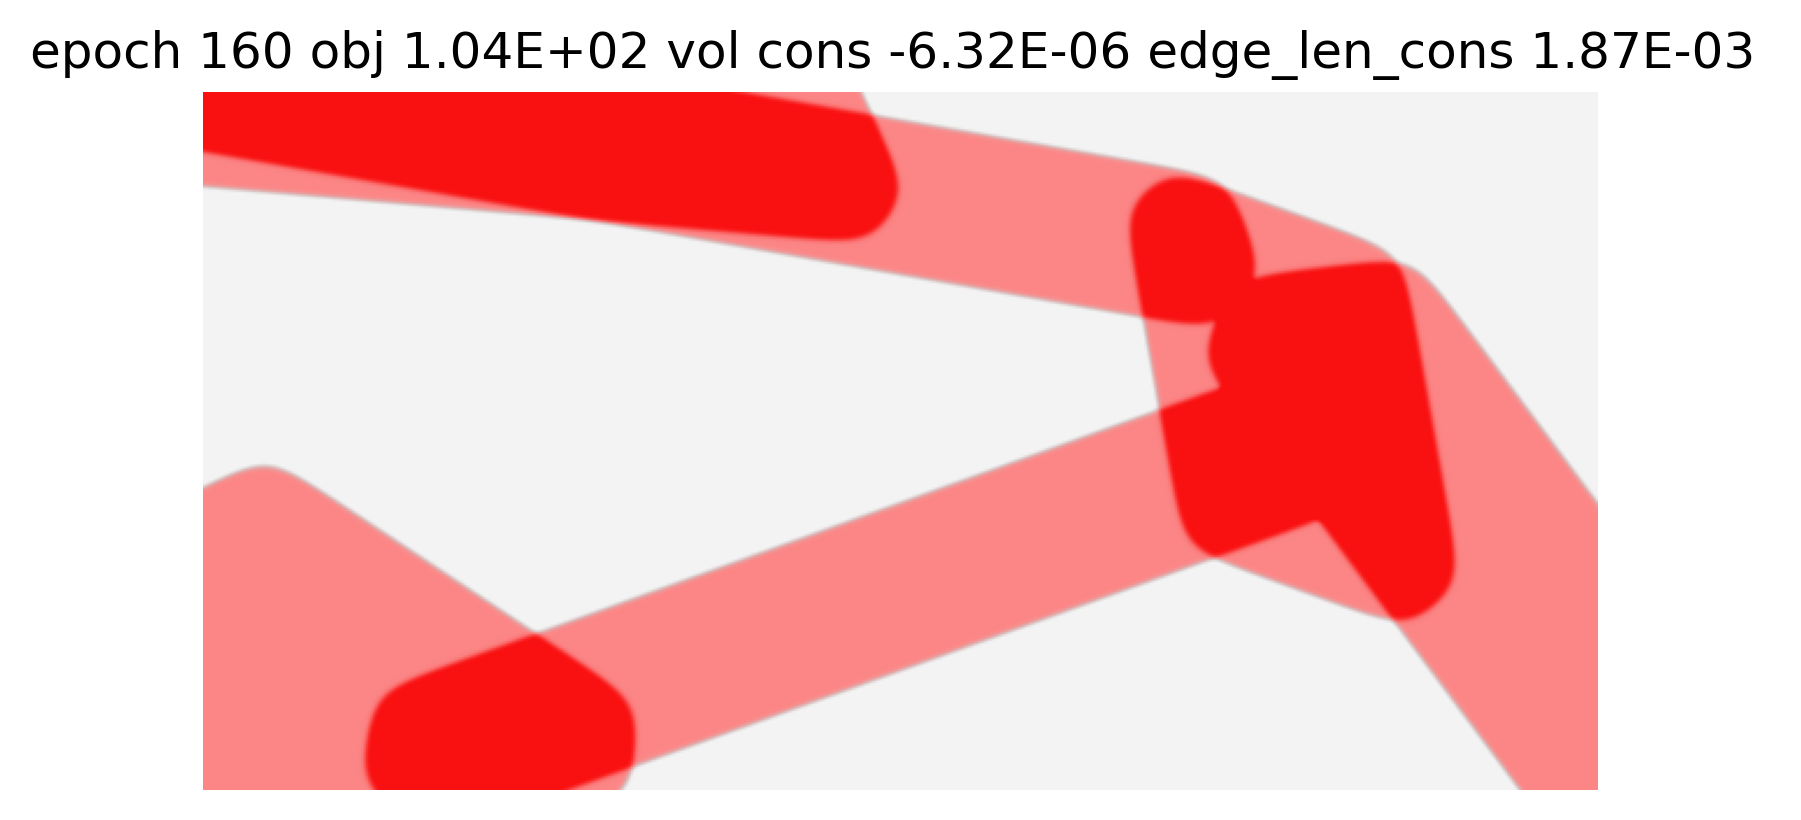

epoch 161 obj 1.04E+02 vol cons 3.58E-07 edge_len_cons 1.19E-03 
epoch 162 obj 1.04E+02 vol cons -1.19E-07 edge_len_cons 1.25E-03 
epoch 163 obj 1.04E+02 vol cons -4.77E-07 edge_len_cons 2.32E-03 
epoch 164 obj 1.04E+02 vol cons -5.96E-07 edge_len_cons 6.22E-04 
epoch 165 obj 1.04E+02 vol cons -1.97E-06 edge_len_cons 1.08E-03 
epoch 166 obj 1.04E+02 vol cons -5.36E-07 edge_len_cons 9.59E-04 
epoch 167 obj 1.04E+02 vol cons -4.17E-07 edge_len_cons -2.66E-04 
epoch 168 obj 1.04E+02 vol cons 1.19E-07 edge_len_cons 3.10E-04 
epoch 169 obj 1.04E+02 vol cons -1.67E-06 edge_len_cons 2.27E-04 
epoch 170 obj 1.04E+02 vol cons -6.74E-06 edge_len_cons 9.47E-05 
epoch 171 obj 1.04E+02 vol cons -2.98E-07 edge_len_cons 2.69E-05 
epoch 172 obj 1.04E+02 vol cons -1.19E-07 edge_len_cons 8.23E-05 
epoch 173 obj 1.04E+02 vol cons -4.17E-07 edge_len_cons 1.88E-05 
epoch 174 obj 1.04E+02 vol cons 0.00E+00 edge_len_cons 5.51E-05 
epoch 175 obj 1.04E+02 vol cons -4.17E-07 edge_len_cons 3.24E-05 
epoch 176 ob

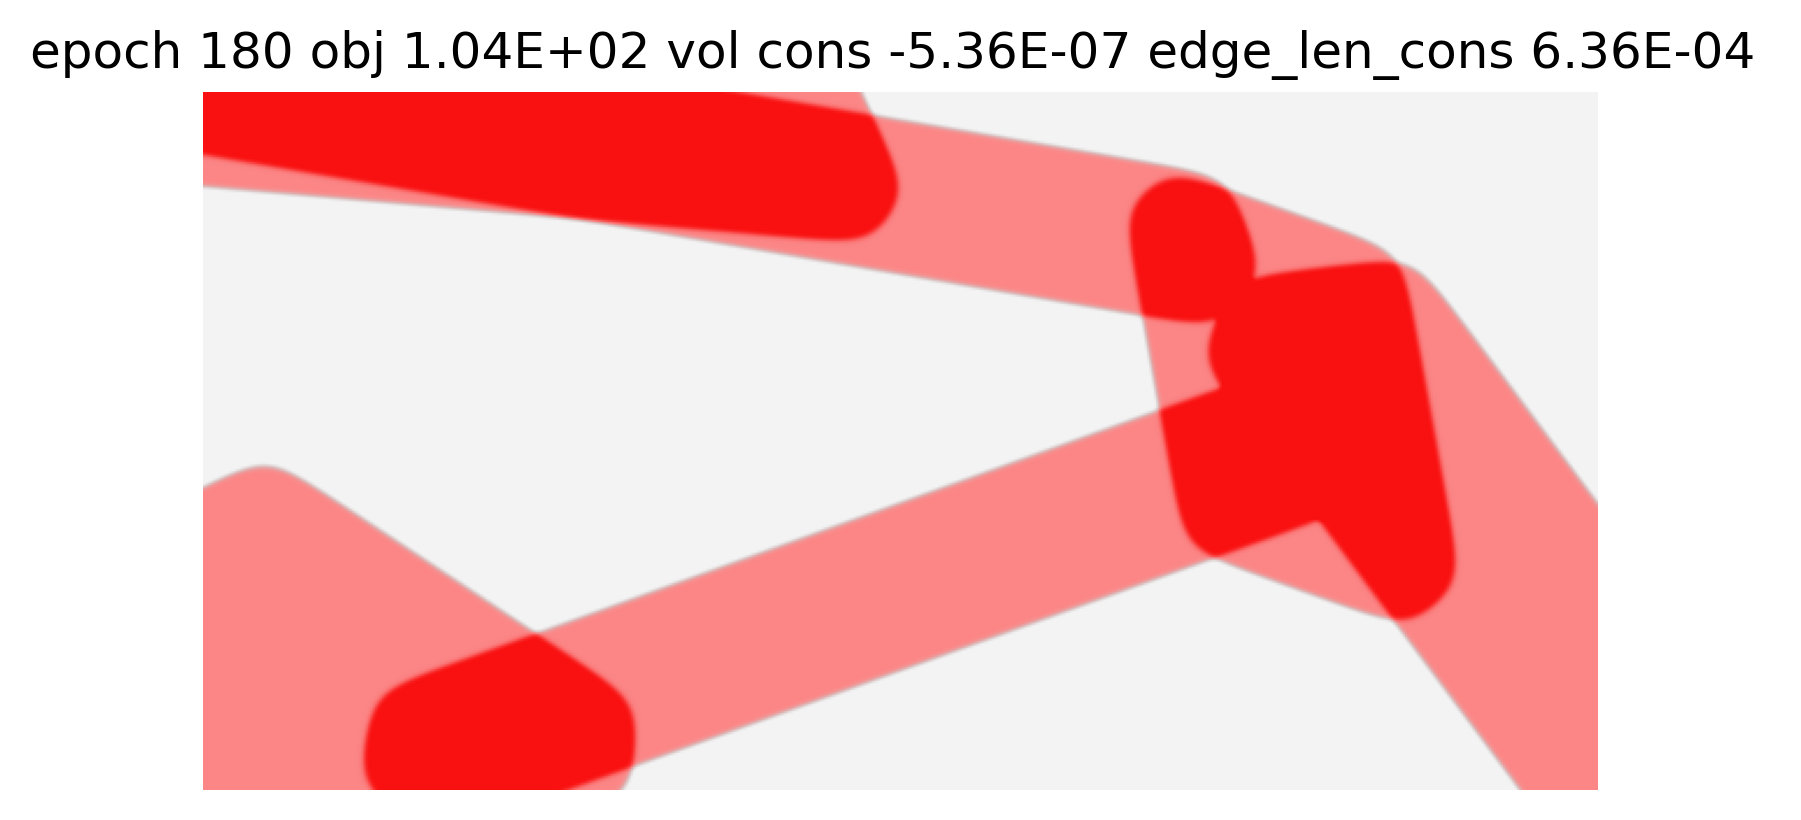

epoch 181 obj 1.04E+02 vol cons 1.60E-05 edge_len_cons 2.42E-03 
epoch 182 obj 1.04E+02 vol cons 7.75E-06 edge_len_cons 9.51E-04 
epoch 183 obj 1.04E+02 vol cons -1.85E-06 edge_len_cons 4.63E-04 
epoch 184 obj 1.04E+02 vol cons 1.19E-07 edge_len_cons 2.85E-04 
epoch 185 obj 1.04E+02 vol cons -5.96E-08 edge_len_cons 7.95E-05 
epoch 186 obj 1.04E+02 vol cons 0.00E+00 edge_len_cons 5.07E-05 
epoch 187 obj 1.04E+02 vol cons -8.34E-07 edge_len_cons 3.12E-05 
epoch 188 obj 1.04E+02 vol cons -1.35E-05 edge_len_cons -1.49E-04 
epoch 189 obj 1.04E+02 vol cons -2.98E-07 edge_len_cons 7.10E-05 
epoch 190 obj 1.04E+02 vol cons -1.79E-07 edge_len_cons 4.36E-05 
epoch 191 obj 1.04E+02 vol cons -5.96E-07 edge_len_cons 3.33E-05 
epoch 192 obj 1.04E+02 vol cons -1.79E-07 edge_len_cons 2.13E-05 
epoch 193 obj 1.04E+02 vol cons 0.00E+00 edge_len_cons 1.78E-05 
epoch 194 obj 1.04E+02 vol cons -5.96E-07 edge_len_cons 2.03E-06 
epoch 195 obj 1.04E+02 vol cons -1.79E-07 edge_len_cons 1.32E-05 
epoch 196 obj 

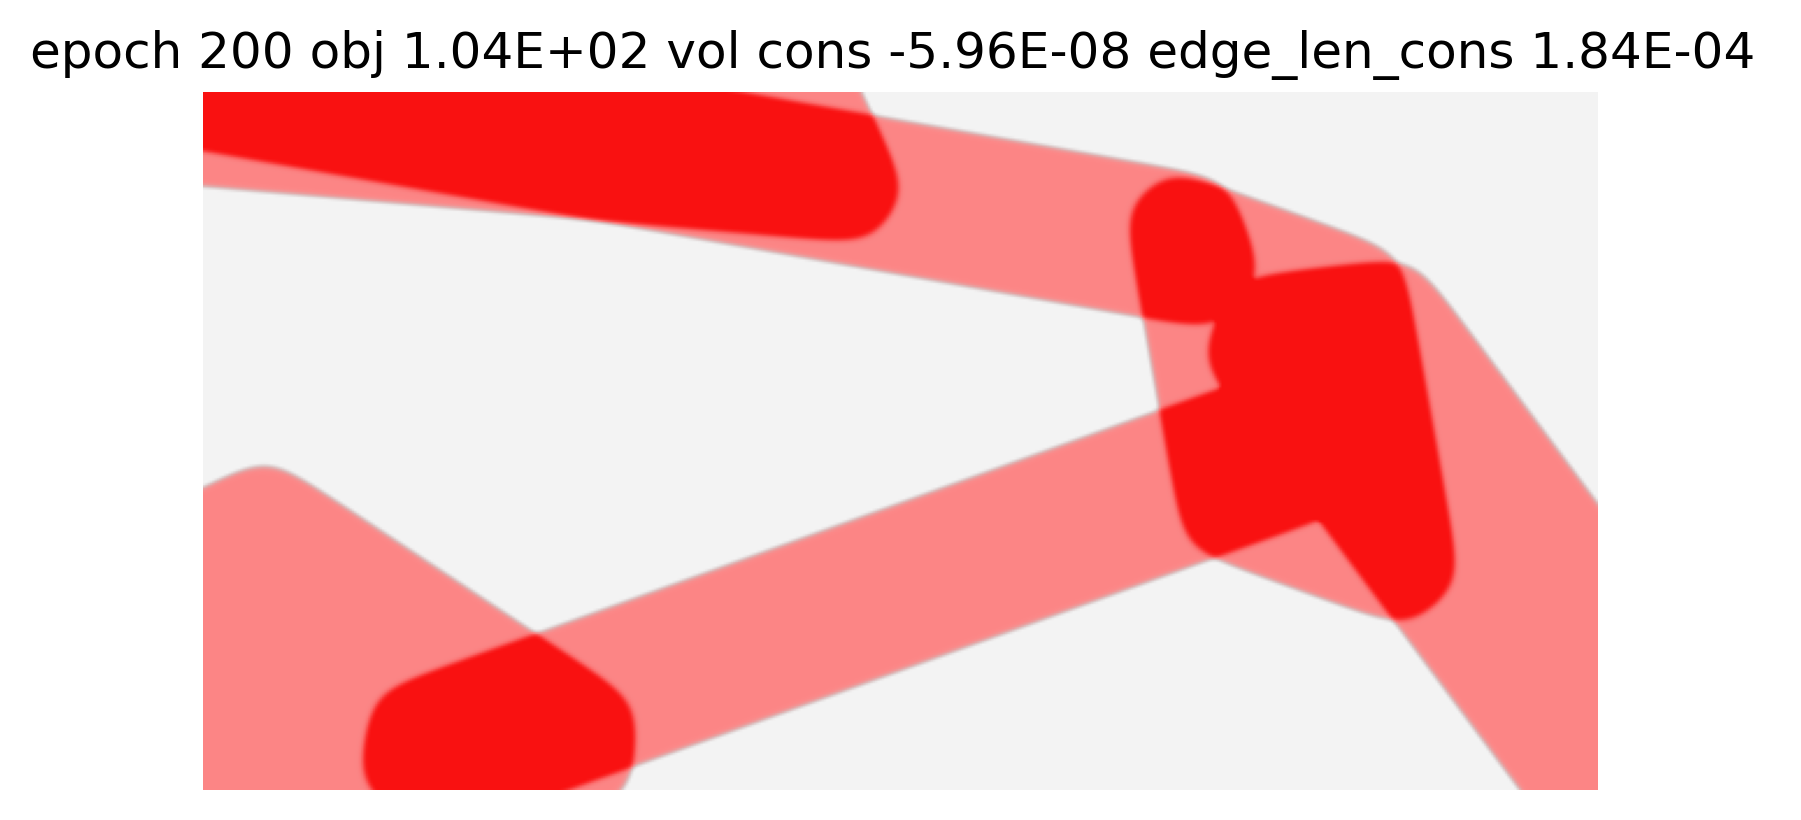

epoch 201 obj 1.04E+02 vol cons 1.19E-07 edge_len_cons 3.75E-04 


In [27]:
optim = Optimizer(lossfn, mesh, poly_extents)

mma_state, history = optim.optimize(init_geom, max_vol_frac=0.5,
                                    allowed_min_edge_length = 2.,
                                    max_iter=201,
                                    plot_interval=20)
plt.show(block=True)

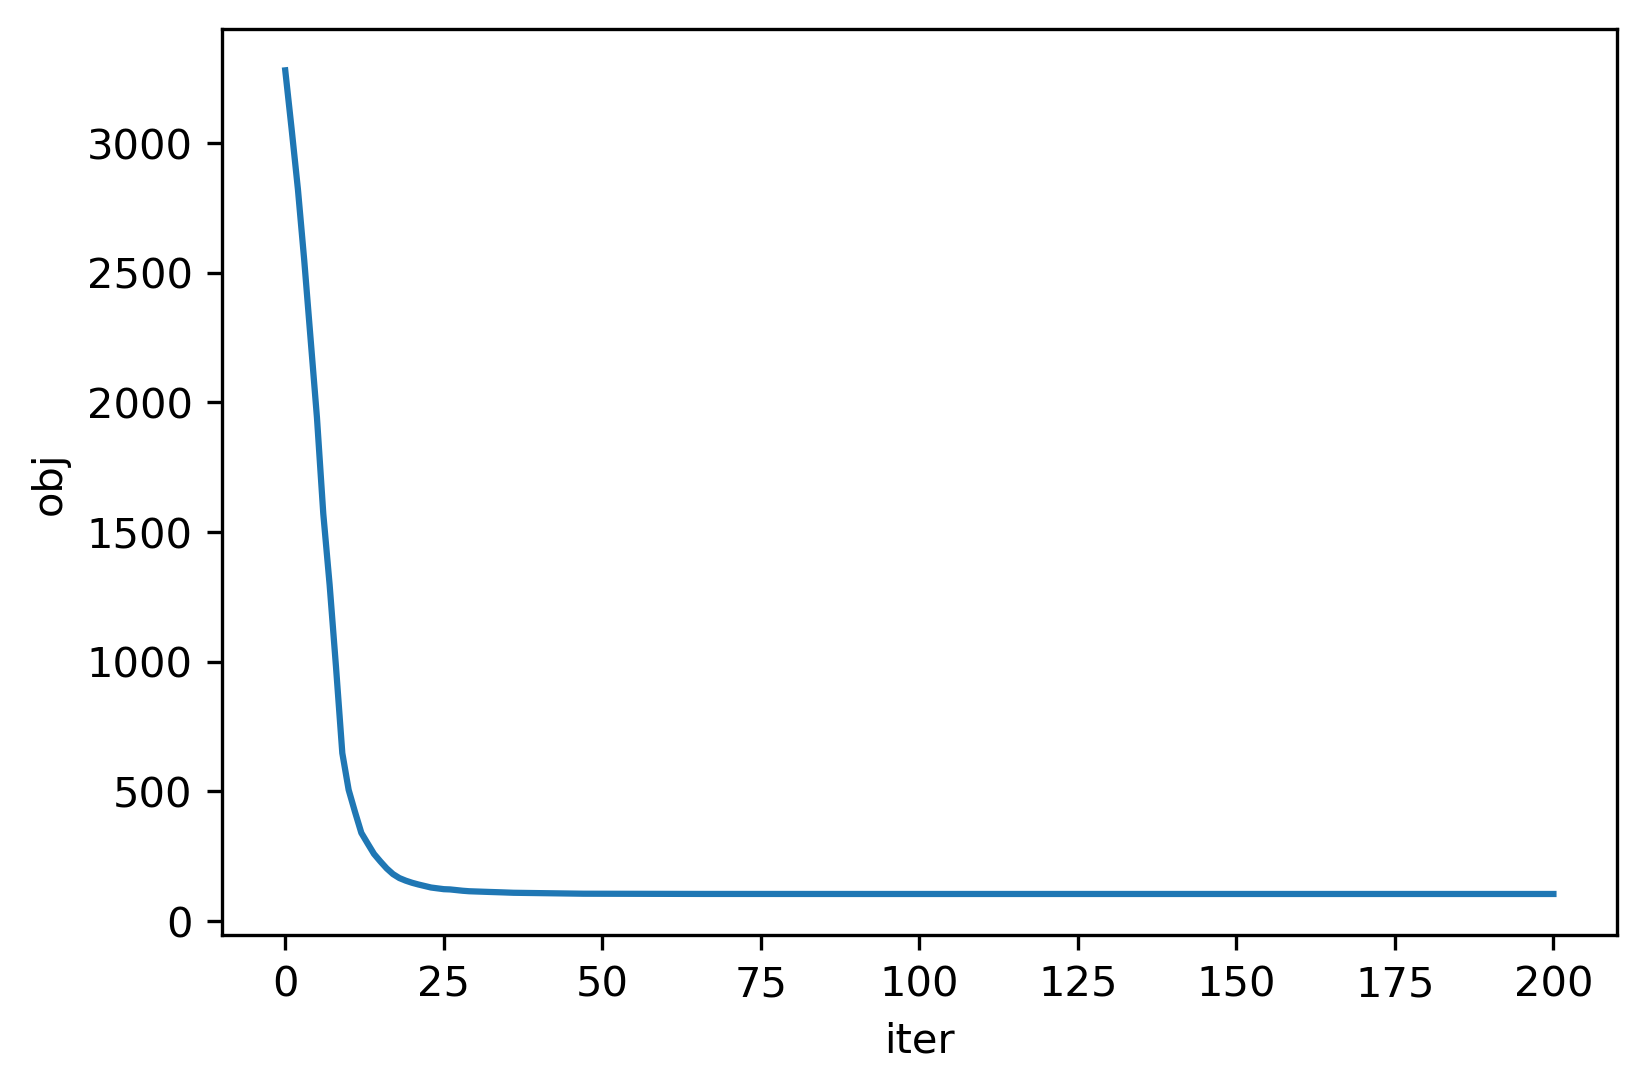

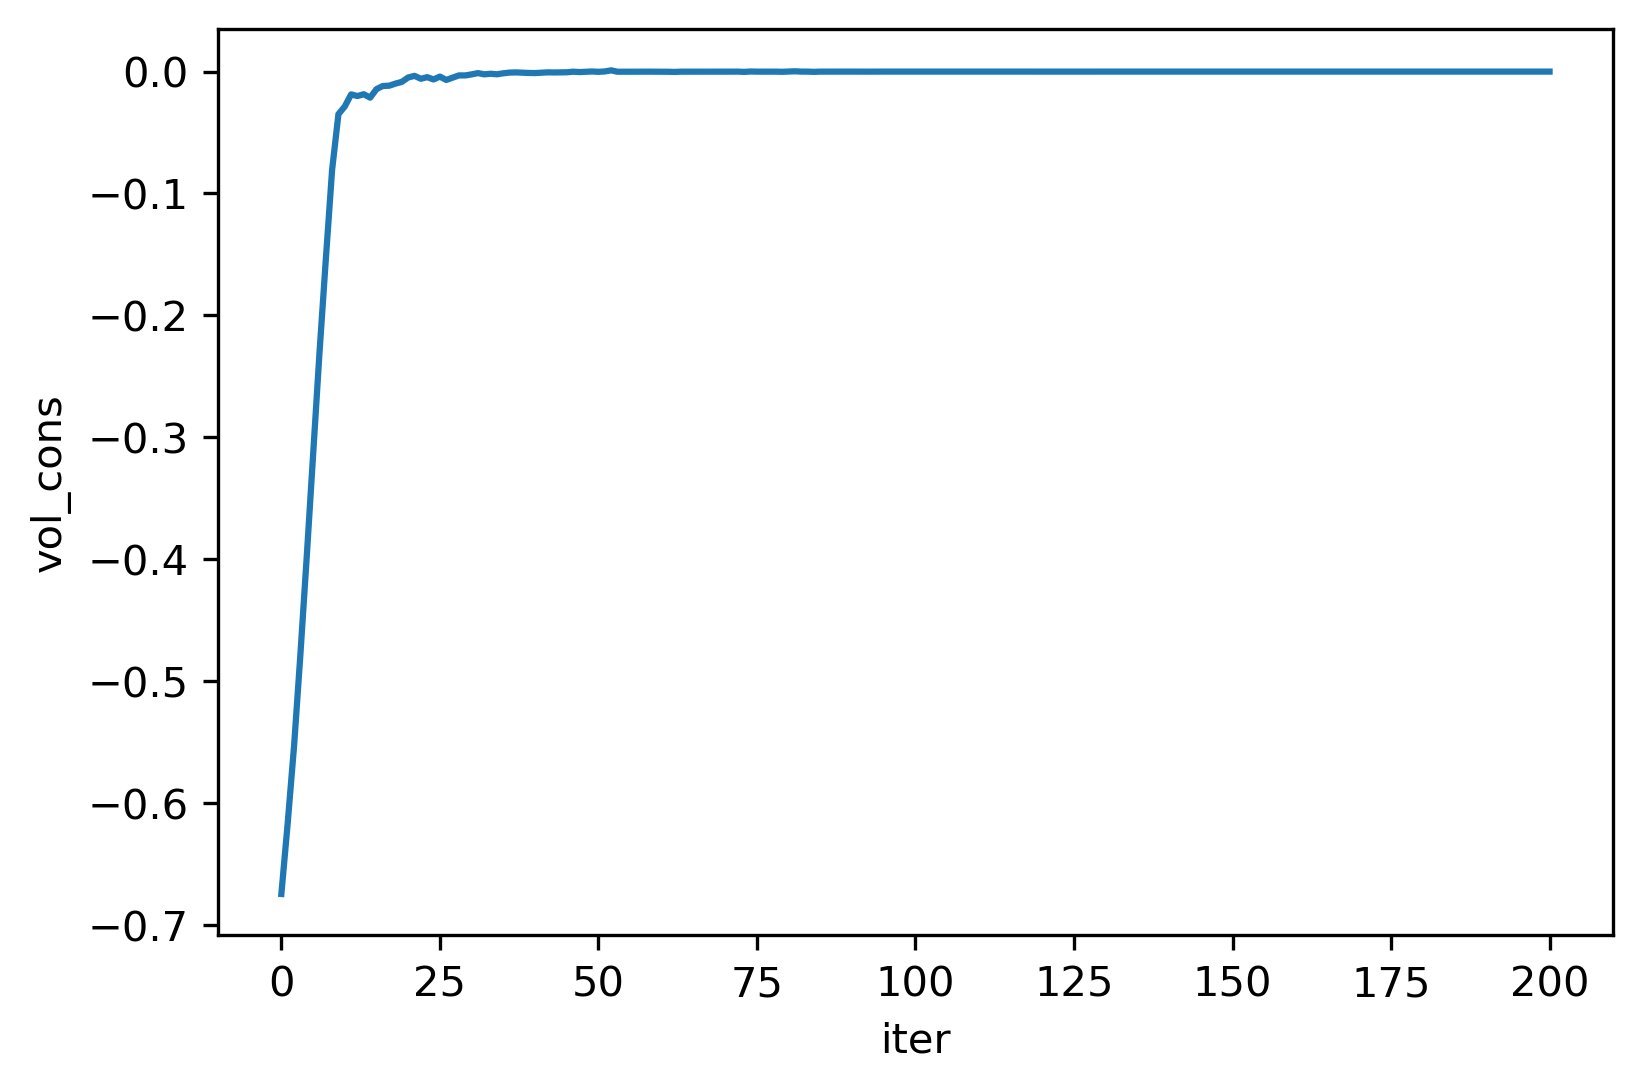

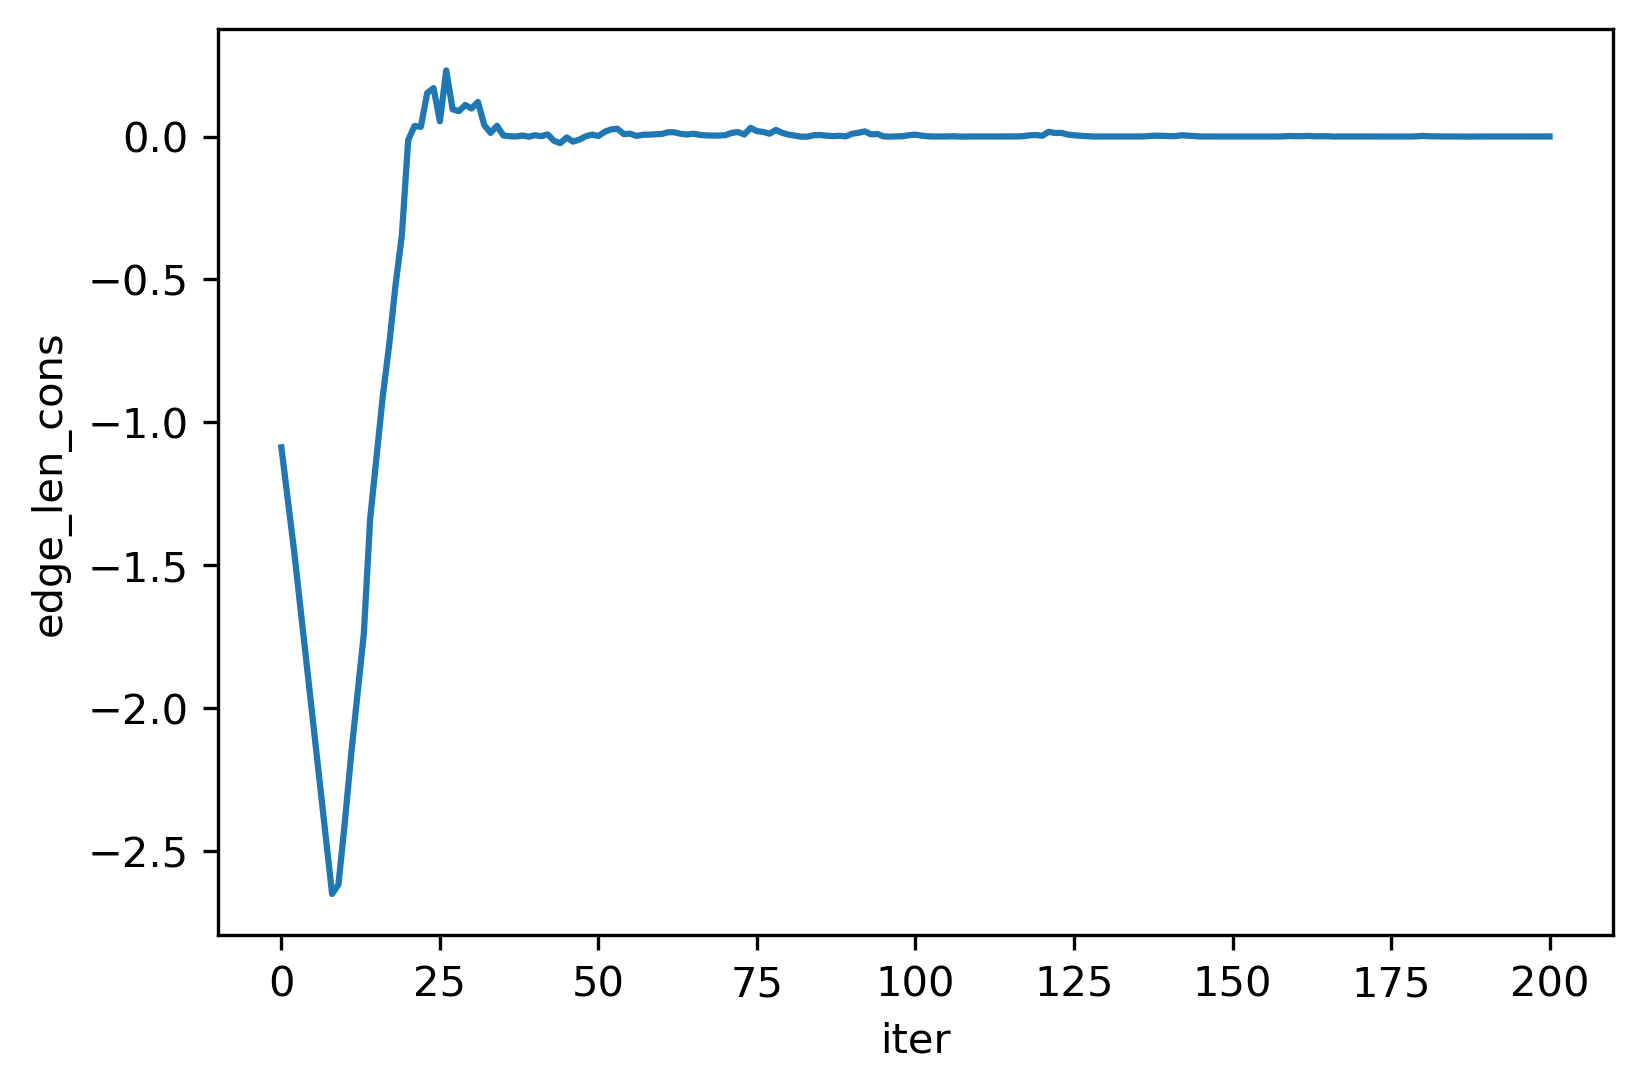

In [28]:
for k in history:
  plt.figure()
  plt.plot(history[k])
  plt.xlabel('iter')
  plt.ylabel(f'{k}')